# **Drug Repositioning**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install networkx scikit-learn node2vec torch dgl pandas numpy


In [ ]:
!pip install --upgrade *
!pip install scipy
!pip install scikit-learn


# Creating Graph (Data Preprocessing)

In [ ]:
#Importing the necessary libraries
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import random

# Loading the datasets
drugs_df = pd.read_csv("/content/drive/Shareddrives/Drug_repositioning/drugsInfo.csv")
disease_targets_df = pd.read_csv("/content/drive/Shareddrives/Drug_repositioning/Disease_with_DrugTarget.csv")
mapping_df = pd.read_csv("/content/drive/Shareddrives/Drug_repositioning/mapping.csv")

# Creating the graph instance
G = nx.DiGraph()

# Adding Drugs and Diseases as nodes
G.add_nodes_from(drugs_df["DrugID"], node_type="drug")
G.add_nodes_from(disease_targets_df["DiseaseID"], node_type="disease")

# Adding Targets as nodes
unique_targets = set(drugs_df["DrugTarget"].dropna().unique())
G.add_nodes_from(unique_targets, node_type="target")

# Adding Drug-Target edges
drug_target_edges = list(zip(drugs_df["DrugID"], drugs_df["DrugTarget"]))
G.add_edges_from(drug_target_edges, relation="interacts_with")

# Adding Target-Disease edges
target_disease_edges = list(zip(disease_targets_df["DrugTargets"], disease_targets_df["DiseaseID"]))
G.add_edges_from(target_disease_edges, relation="associated_with")

# Adding Drug-Disease known interactions
drug_disease_edges = list(zip(mapping_df["DrugID"], mapping_df["DiseaseID"]))
G.add_edges_from(drug_disease_edges, relation="treats")

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Generating the Node Embeddings
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
node_embedding_dict = {str(node): model.wv[str(node)] for node in G.nodes()}

# Creating positive and negative samples
positive_edges = drug_disease_edges
negative_edges = set()
drug_nodes = list(drugs_df["DrugID"].unique())
disease_nodes = list(disease_targets_df["DiseaseID"].unique())

while len(negative_edges) < len(positive_edges):
    d = random.choice(drug_nodes)
    dis = random.choice(disease_nodes)
    if (d, dis) not in G.edges():
        negative_edges.add((d, dis))
negative_edges = list(negative_edges)

# Performing Train-Test Split for edges
edges = positive_edges + negative_edges
labels = [1] * len(positive_edges) + [0] * len(negative_edges)
edges_train, edges_test, labels_train, labels_test = train_test_split(edges, labels, test_size=0.2, random_state=42)

# Converting edges to feature vectors
def edge_to_feature(edge_list, embedding_dict):
    return [np.concatenate([embedding_dict.get(str(edge[0]), np.zeros(64)), embedding_dict.get(str(edge[1]), np.zeros(64))]) for edge in edge_list]

#Creating train and test inputs
X_train = edge_to_feature(edges_train, node_embedding_dict)
X_test = edge_to_feature(edges_test, node_embedding_dict)


### **Graph Structure: Graph has 5559 nodes and 45183 edges.**

# **Data Modelling and Testing (Without Hyperparameter Tuning)**

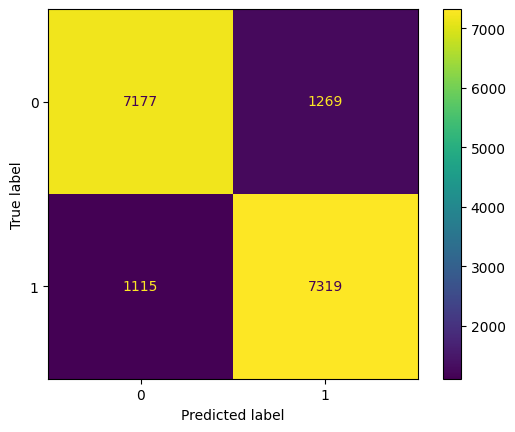

Random Forest AUC-ROC: 0.8588, Accuracy: 0.8588


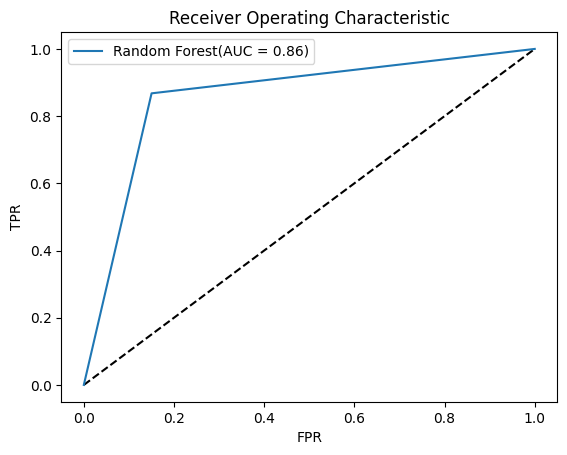

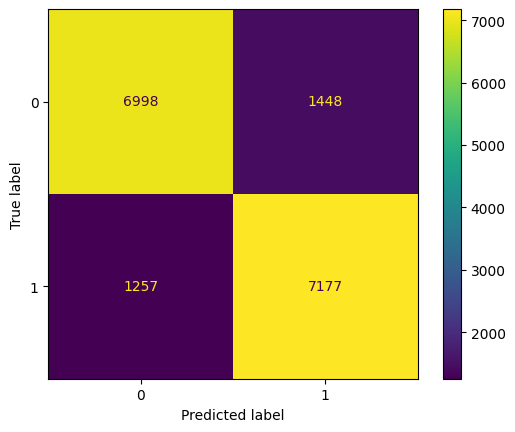

Logistic Regression AUC-ROC: 0.8398, Accuracy: 0.8398


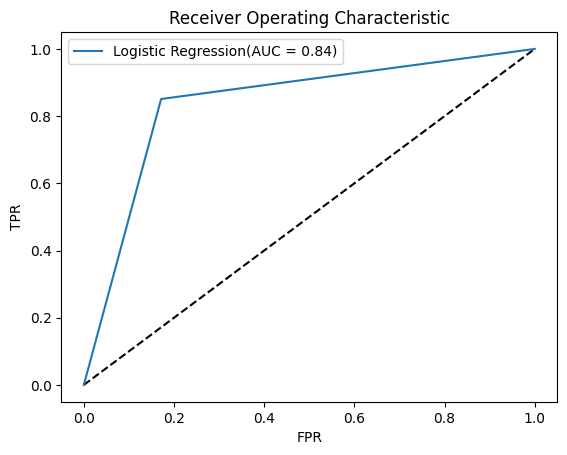

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import joblib
# Creating model instances
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

model_instance=[]
#Fitting various models to the data and calculating accuracy and auc-roc
for name, model in models.items():
    model.fit(X_train, labels_train)
    predictions = model.predict(X_test)
    model_instance.append(model)
    confusion_matrix = metrics.confusion_matrix(labels_test, predictions)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
    cm_display.plot()
    plt.show()
    roc_auc = roc_auc_score(labels_test, predictions)
    accuracy = accuracy_score(labels_test, predictions)
    print(f"{name} AUC-ROC: {roc_auc:.4f}, Accuracy: {accuracy:.4f}")
    fpr, tpr, thresholds = metrics.roc_curve(labels_test, predictions)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=name+"(AUC = %0.2f)" % roc_auc)
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title('Receiver Operating Characteristic')
    plt.show()
    joblib.dump(model, f"{name.replace(' ', '_')}_model.pkl")

# **Assignment 2**

# **Dimensionality Reduction**

## Principle Component Analysis (PCA)

In [ ]:

from sklearn.decomposition import PCA

# Apply PCA to reduce the dimensionality of the node embeddings
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [ ]:

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_pca, labels_train)  # Using the PCA-transformed data
    predictions = model.predict(X_test_pca)
    roc_auc = roc_auc_score(labels_test, predictions)
    accuracy = accuracy_score(labels_test, predictions)
    print(f"{name} AUC-ROC: {roc_auc:.4f}, Accuracy: {accuracy:.4f}")

Random Forest AUC-ROC: 0.8219, Accuracy: 0.8219
Logistic Regression AUC-ROC: 0.7712, Accuracy: 0.7712


**Inference: In PCA, Random Forest shows better results**

Now, changing the number of components to find the best result

In [ ]:

best_accuracies = {}
best_roc_aucs = {}

for n_components in range(1, 18):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    for name, model in models.items():
        model.fit(X_train_pca, labels_train)
        predictions = model.predict(X_test_pca)
        roc_auc = roc_auc_score(labels_test, predictions)
        accuracy = accuracy_score(labels_test, predictions)

        if name not in best_accuracies or accuracy > best_accuracies[name][0]:
            best_accuracies[name] = (accuracy, n_components)

        if name not in best_roc_aucs or roc_auc > best_roc_aucs[name][0]:
            best_roc_aucs[name] = (roc_auc, n_components)

print("Best Accuracies:")
for name, (accuracy, n_components) in best_accuracies.items():
    print(f"{name}: Accuracy = {accuracy:.4f}, n_components = {n_components}")

print("\nBest ROC-AUCs:")
for name, (roc_auc, n_components) in best_roc_aucs.items():
    print(f"{name}: ROC-AUC = {roc_auc:.4f}, n_components = {n_components}")


Best Accuracies:
Random Forest: Accuracy = 0.8416, n_components = 16
Logistic Regression: Accuracy = 0.7992, n_components = 17

Best ROC-AUCs:
Random Forest: ROC-AUC = 0.8416, n_components = 16
Logistic Regression: ROC-AUC = 0.7992, n_components = 17


## Linear Discriminant Analysis (LDA)

In [ ]:


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Apply LDA to reduce the dimensionality of the node embeddings
lda = LDA(n_components=1)  # You can adjust the number of components
X_train_lda = lda.fit_transform(X_train, labels_train)
X_test_lda = lda.transform(X_test)

# Now you can use X_train_lda and X_test_lda for training and testing your models.

# Example:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_lda, labels_train)  # Using the LDA-transformed data
    predictions = model.predict(X_test_lda)
    roc_auc = roc_auc_score(labels_test, predictions)
    accuracy = accuracy_score(labels_test, predictions)
    print(f"{name} AUC-ROC: {roc_auc:.4f}, Accuracy: {accuracy:.4f}")


Random Forest AUC-ROC: 0.7676, Accuracy: 0.7676
Logistic Regression AUC-ROC: 0.8393, Accuracy: 0.8393


**Inference: In LDA, Logistic Regression shows better results**

In [ ]:

import numpy as np
best_accuracies = {}
best_roc_aucs = {}

for n_components in range(1, min(len(np.unique(labels_train)), 18)):  # Use min to avoid errors if n_components > unique labels
    lda = LDA(n_components=n_components)
    try:
        X_train_lda = lda.fit_transform(X_train, labels_train)
        X_test_lda = lda.transform(X_test)

        for name, model in models.items():
            model.fit(X_train_lda, labels_train)
            predictions = model.predict(X_test_lda)
            roc_auc = roc_auc_score(labels_test, predictions)
            accuracy = accuracy_score(labels_test, predictions)

            if name not in best_accuracies or accuracy > best_accuracies[name][0]:
                best_accuracies[name] = (accuracy, n_components)

            if name not in best_roc_aucs or roc_auc > best_roc_aucs[name][0]:
                best_roc_aucs[name] = (roc_auc, n_components)
    except ValueError:
        print(f"LDA failed for n_components={n_components}, likely due to insufficient unique labels.")

print("Best Accuracies (LDA):")
for name, (accuracy, n_components) in best_accuracies.items():
    print(f"{name}: Accuracy = {accuracy:.4f}, n_components = {n_components}")

print("\nBest ROC-AUCs (LDA):")
for name, (roc_auc, n_components) in best_roc_aucs.items():
    print(f"{name}: ROC-AUC = {roc_auc:.4f}, n_components = {n_components}")


Best Accuracies (LDA):
Random Forest: Accuracy = 0.7676, n_components = 1
Logistic Regression: Accuracy = 0.8393, n_components = 1

Best ROC-AUCs (LDA):
Random Forest: ROC-AUC = 0.7676, n_components = 1
Logistic Regression: ROC-AUC = 0.8393, n_components = 1


**Inference:** While both PCA and LDA results in lower accuracies over model without dimensionality reduction, <br>
PCA shows better results with Random Forest while LDA shows better results with Logistic Regression

## **Grid Search and Hyperparameter Tuning**

In [ ]:

from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']  # Add 'saga' if you have a newer sklearn version and want to use L1 with multiclass
    }
}

best_models = {}

for name, model in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, labels_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

# Now use the best_models dictionary to evaluate the models with optimized parameters

for name, model in best_models.items():
    predictions = model.predict(X_test)
    roc_auc = roc_auc_score(labels_test, predictions)
    accuracy = accuracy_score(labels_test, predictions)
    print(f"{name} (Optimized) AUC-ROC: {roc_auc:.4f}, Accuracy: {accuracy:.4f}")

    # You can also generate confusion matrix and ROC curve plots here if needed


Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Random Forest (Optimized) AUC-ROC: 0.8600, Accuracy: 0.8600
Logistic Regression (Optimized) AUC-ROC: 0.8401, Accuracy: 0.8401


## **Random Search and Hyperparameter Tuning**

In [ ]:

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import joblib
# Creating model instances
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}


# Define the parameter distributions for random search
param_dist = {
    'Random Forest': {
        'n_estimators': sp_randint(50, 201),
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': sp_randint(2, 11),
        'min_samples_leaf': sp_randint(1, 5)
    },
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']  # Add 'saga' if you have a newer sklearn version and want to use L1 with multiclass
    }
}

best_models = {}
for name, model in models.items():
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist[name], n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
    random_search.fit(X_train, labels_train)
    best_models[name] = random_search.best_estimator_
    print(f"Best parameters for {name}: {random_search.best_params_}")

# Now use the best_models dictionary to evaluate the models with optimized parameters
for name, model in best_models.items():
    predictions = model.predict(X_test)
    roc_auc = roc_auc_score(labels_test, predictions)
    accuracy = accuracy_score(labels_test, predictions)
    print(f"{name} (Optimized) AUC-ROC: {roc_auc:.4f}, Accuracy: {accuracy:.4f}")
    # You can also generate confusion matrix and ROC curve plots here if needed

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 181}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for Logistic Regression: {'solver': 'liblinear', 'penalty': 'l1', 'C': 10}
Random Forest (Optimized) AUC-ROC: 0.8627, Accuracy: 0.8627
Logistic Regression (Optimized) AUC-ROC: 0.8446, Accuracy: 0.8445


# **Testing with real-life disease and drug**

In [ ]:
def predict_drugs_and_proteins_for_disease(disease_name):
    if disease_name not in node_embedding_dict:
        print("Disease not found in the graph.")
        return []

    disease_embedding = node_embedding_dict[disease_name]
    drug_scores = {}
    drug_protein_map = {}

    for drug in drugs_df["DrugID"].unique():
        if drug in node_embedding_dict:
            drug_embedding = node_embedding_dict[drug]
            feature_vector = np.concatenate([disease_embedding, drug_embedding]).reshape(1, -1)
            score = model_instance[0].predict_proba(feature_vector)[0, 1]  # Probability of being a positive link
            drug_scores[drug] = score
            # Finding associated targets
            associated_targets = drugs_df[drugs_df["DrugID"] == drug]["DrugTarget"].dropna().unique().tolist()
            drug_protein_map[drug] = associated_targets

    sorted_drugs = sorted(drug_scores.items(), key=lambda x: x[1], reverse=True)
    top_drugs = [(drug, drug_protein_map[drug]) for drug, score in sorted_drugs[:10]]  # Return top 10 predicted drugs with associated targets
    return top_drugs

disease_ids=["MESH:D018352","MESH:D000506"]
disease_name = ["Corona Virus","Alopecia Areata"]
for i in range(2):
    print(disease_name[i])
    predicted_drugs_with_proteins = predict_drugs_and_proteins_for_disease(disease_ids[i])
    print(f"Predicted drugs and associated proteins for {disease_name[i]}: {predicted_drugs_with_proteins}")

Corona Virus
Predicted drugs and associated proteins for Corona Virus: [('DB04574', ["['P03372', 'Q92731']"]), ('DB04570', ["['P42971', 'P02918', 'P02919', 'P24228']"]), ('DB11431', ["['Q25634']"]), ('DB01055', ["['P34896', 'P13500', 'P14679']"]), ('DB01582', ["['P0AC13']"]), ('DB00957', ["['P06401', 'P03372', 'P10275']"]), ('DB09074', ["['P09874', 'Q9UGN5', 'Q9Y6F1', 'P42330']"]), ('DB04862', ["['P0C0H6']"]), ('DB06782', ["['P05067']"]), ('DB05088', ["['P05067']"])]
Alopecia Areata
Predicted drugs and associated proteins for Alopecia Areata: [('DB00509', ["['P10827', 'P10828', 'P07202']"]), ('DB01217', ["['P11511']"]), ('DB01411', ["['Q9Y271', 'P01375', 'P05113', 'P12724', 'P19838', 'Q02817', 'Q00653', 'P19838']"]), ('DB12442', ["['P07900']"]), ('DB14487', ["['P46663', 'P16455', 'P04075', 'P68104', 'P06733', 'O14556', 'P15531', 'P07237', 'P30101', 'Q06830', 'P78330', 'P60174', 'P49411', 'P03372', 'P08700', 'P02795', 'O14618', 'Q13547', 'P56524', 'P29372', 'P04279', 'P00441', 'Q9BY41',